# Lecture 12 - Mixture Models & Expectation-Maximization Algorithm

Last class, we introduced the **Naive Bayes Classifier**, a type of probabilistic generative model.

* In probabilistic generative models, we are interested in learning the posterior probability of each class in order to determine regions in our feature space that make each class more likely.


<div class="alert alert-info">
    <b>Naive Bayes Classifier</b>
    
Decide class $C_k$ if:
$$P(C_k|\mathbf{x}) > P(C_j|\mathbf{x}), \forall j\neq k$$

we can rewrite it as:

$$P(\mathbf{x}|C_k)P(C_k) > P(\mathbf{x}|C_j)P(C_j), \forall j\neq k$$
    
where $P(\mathbf{x}|C_k)$ is the data likelihood of data samples in class $C_k$ and $P(C_k)$ is the prior probability of class $C_k$.
</div> 

Today, we will consider the cases where the data likelihood of each class is better described as a **Mixture Model**. 

* To illustrate this, let's use our synthetic data generator function:

In [1]:
from scipy.stats import multivariate_normal

import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')

In [2]:
def generateData(mean1, mean2, cov1, cov2, N1, N2):
    # We are generating data from two Gaussians to represent two classes
    # In practice, we would not do this - we would just have data from the problem we are trying to understand
    class1X = np.random.multivariate_normal(mean1, cov1, N1)
    class2X = np.random.multivariate_normal(mean2, cov2, N2)
    
    plt.scatter(class1X[:,0], class1X[:,1], c='r')
    plt.scatter(class2X[:,0], class2X[:,1])
    plt.xlabel('Feature 1'); plt.ylabel('Feature 2')
    plt.axis([-4,4,-4,4])
    return class1X, class2X

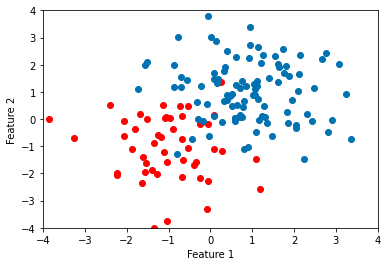

In [3]:
mean1 = [-1, -1]
mean2 = [1, 1]
cov1 = [[1,0],[0,1]]
cov2 = [[1,0],[0,1]]
N1 = 50
N2 = 100

class1X, class2X = generateData(mean1, mean2, cov1, cov2, N1, N2)

In order to estimate the **data likelihood**, we can use the MLE estimates for the distribution parameters and fit a distributional form for the data likelihood.

* Before we proceed with the parameter estimation, we need to assume a shape for the distribution. In practice, this selection is a *parameter* and needs to be validated using cross-validation.

## MLE Parameter Estimation Steps

Assuming the classes follow a (bivariate or 2-D) Gaussian distribution and, for simplicity, let's assume the covariance matrices are **isotropic**, that is, $\Sigma_k = \sigma^2_k \mathbf{I}$.

The MLE steps for parameter estimation are:

1. Write down the observed data likelihood, $\mathcal{L}^0$

\begin{align}
\mathcal{L}^0 &= P(x_1,x_2,\dots,x_N|C_k)\\
&= \prod_{n=1}^N P(x_n|C_k),\text{ data samples are i.i.d.} \\
&= \prod_{n=1}^N \frac{1}{(2\pi)^{1/2} |\Sigma|^{1/2}} \exp\left\{-\frac{1}{2}(x_n-\mu_k)^T\Sigma_k^{-1}(x_n-\mu_k)\right\}\\
&= \prod_{n=1}^N \frac{1}{(2\pi)^{1/2} |\sigma_k^2 \mathbf{I}|^{1/2}} \exp\left\{-\frac{1}{2\sigma_k^2}(x_n-\mu_k)^T\mathbf{I}(x_n-\mu_k)\right\}\\
&= \prod_{n=1}^N \frac{1}{(2\pi)^{1/2} (\sigma_k^2)^{1/2}} \exp\left\{-\frac{1}{2\sigma_k^2}(x_n-\mu_k)^T(x_n-\mu_k)\right\}
\end{align}

2. Take the log-likelihood, $\mathbf{L}$. This *trick* helps in taking derivatives.

\begin{align}
\mathcal{L} &= \ln\left(\mathcal{L}^0\right) \\
&= \sum_{n=1}^N -\frac{1}{2}\ln 2\pi - \frac{1}{2}\ln\sigma_k^2 - \frac{1}{2\sigma_k^2}(x_n-\mu_k)^T(x_n-\mu_k)
\end{align}

3. Take the derivative of the log-likelihood function with respect to the parameters of interest. For Gaussian distribution they are the mean and covariance.



\begin{align}
\frac{\partial \mathcal{L}}{\partial \mu_k} &= 0\\
\sum_{n\in C_k} \frac{1}{\sigma_k^2} (x_n - \mu_k) &= 0\\
\sum_{n\in C_k} (x_n - \mu_k) &= 0 \\
\sum_{n\in C_k} x_n - \sum_{n\in C_k} \mu_k &= 0 \\
\sum_{n\in C_k} x_n - N_k \mu_k &= 0 \\
\mu_k & = \frac{1}{N_k} \sum_{n\in C_k} x_n
\end{align}

This is the sample mean for each class. And,

\begin{align}
\frac{\partial \mathcal{L}}{\partial \sigma_k^2} &= 0\\
\sum_{n\in C_k} -\frac{1}{2\sigma_k^2} + \frac{2(x_n - \mu_k)^T(x_n - \mu_k)}{(2\sigma_k^2)^2} &=0 \\
\sum_{n\in C_k} -1 + \frac{(x_n - \mu_k)^T(x_n - \mu_k)}{\sigma_k^2} &=0 \\
\sum_{n\in C_k} \frac{(x_n - \mu_k)^T(x_n - \mu_k)}{\sigma_k^2} &=N_k \\
\sigma_k^2 &= \sum_{n\in C_k} \frac{(x_n - \mu_k)^T(x_n - \mu_k)}{N_k}
\end{align}

This is the sample variance for each class. Then we can create $\Sigma_k = \sigma_k^2 \mathbf{I}$, which is the (biased) sample covariance for each class.

## Estimating Data Likelihood

In [4]:
mu1 = np.mean(class1X, axis=0)
print('Mean of Class 1: ', mu1)

cov1 = np.cov(class1X.T)
print('Covariance of Class 1: ',cov1)

mu2 = np.mean(class2X, axis=0)
print('Mean of Class 2: ',mu2)

cov2 = np.cov(class2X.T)
print('Covariance of Class 2: ',cov2)

Mean of Class 1:  [-1.00961314 -1.00449753]
Covariance of Class 1:  [[ 0.92638401 -0.10924024]
 [-0.10924024  1.3417774 ]]
Mean of Class 2:  [0.8969322  1.00763736]
Covariance of Class 2:  [[ 1.13017184 -0.13635514]
 [-0.13635514  1.21671894]]


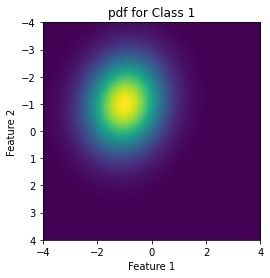

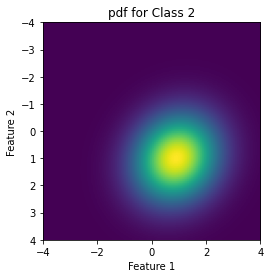

In [5]:
# Compute a grid of values for x and y 
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
xm, ym = np.meshgrid(x, y)
X = np.dstack([xm,ym])

# Let's plot the probabaility density function (pdf) for each class
y1 = multivariate_normal.pdf(X, mean=mu1, cov=cov1) #P(x|C1)
y2 = multivariate_normal.pdf(X, mean=mu2, cov=cov2) #P(x|C2)

plt.imshow(y1, extent=[-4,4,4,-4]); plt.xlabel('Feature 1'); plt.ylabel('Feature 2'); plt.title('pdf for Class 1'); plt.show()
plt.imshow(y2, extent=[-4,4,4,-4]); plt.xlabel('Feature 1'); plt.ylabel('Feature 2'); plt.title('pdf for Class 2'); plt.show()

In this example, we look at a relatively simple model where we model the each class group with a single Gaussian probability density function (pdf).

* Consider the following example: would a multivariate Gaussian be able to represent this class group?

In [6]:
from sklearn.datasets import make_blobs

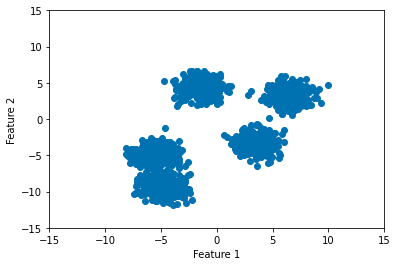

In [8]:
N = 1500
groups = 5

data, _ = make_blobs(n_samples = N, centers = groups)

plt.scatter(data[:,0],data[:,1])
plt.axis([-15,15,-15,15])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2');

* If we assume a single Gaussian distribution for this classes' data points, we would obtain a very poor estimate of the true underlying data likelihood:

In [9]:
mu1 = np.mean(data, axis=0)
print('Mean of Class 1: ', mu1)

cov1 = np.cov(data.T)
print('Covariance of Class 1: ',cov1)

Mean of Class 1:  [-0.33598961 -1.95633884]
Covariance of Class 1:  [[22.49370031 14.38471999]
 [14.38471999 27.93582072]]


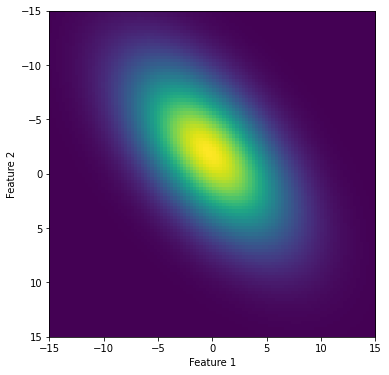

In [10]:
# Compute a grid of values for x and y 
x = np.linspace(-15, 15, 100)
y = np.linspace(-15,15, 100)
xm, ym = np.meshgrid(x, y)
X = np.dstack([xm,ym])

y1 = multivariate_normal.pdf(X, mean=mu1, cov=cov1)

plt.figure(figsize=(6,6))
plt.imshow(y1, extent=[-15,15,15,-15])
plt.xlabel('Feature 1'); plt.ylabel('Feature 2');

# Mixture Models

We can better represent this data with a **mixture model**:

$$p(x|\Theta) = \sum_{k=1}^K \pi_k P(x|\Theta_k)$$

where $\Theta = \{\Theta_k\}_{k=1}^K$ are set of parameters that define the distributional form in the probabilistic model $P(\bullet|\Theta_k)$ and 

\begin{align}
0 & \leq \pi_k \leq 1\\
& \sum_k \pi_k = 1
\end{align}

If the probabilistic model $P(\bullet|\Theta_k)$ is assumed to be a Gaussian distribution, then the above mixture model is a **Gaussian Mixture Model (GMM)**

$$P(x|\Theta) = \sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k, \Sigma_k)$$

where $\Theta_k=\{\mu_k, \Sigma_k, \pi_k\}, \forall k$ are the mean, covariance and weight of each Gaussian distribution, and, again, $0 \leq \pi_k \leq 1$ with $\sum_k \pi_k = 1$.

## Simulating Gaussian Mixture Models

**<font color=blue>Exercise :</font> In code, how would you draw a sample from a Gaussian Mixture Model? from a mixture model in general?**

* Note that in a Gaussian Mixture Model we are assuming that each data point $x_i$ was drawn from only one Gaussian. 

* Each data point $x_i$ has *hard membership*.

* Each Gaussian in the Mixture Model will have its own $0 \leq \pi_k \leq 1$.

To simulate an event with arbitary probability $P_E$:

1. Generate a random number R that is equally likely to be between 0 and 1.

2. If $R \le P_E$, then in the simulation, the event occurs. Otherwise it does not occur.

In [11]:
?npr.uniform

In [12]:
# Example simulation
Pe=0.13

num_sims=100000
event_count=0
for sim in range(num_sims):
    
    if npr.uniform()<=Pe:
        event_count+=1
        
print('According to the simulation Pe =~',event_count/num_sims)

According to the simulation Pe =~ 0.13095


Let's consider the case where we have 4 Gaussian in the Mixture model with weights $\{0.4,0.25,0.25,0.1\}$:

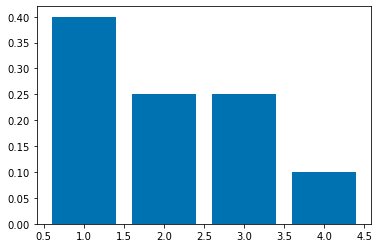

In [14]:
Pis = [0.4, 0.25, 0.25, 0.1]

plt.bar(range(1,5), Pis);

We need to first (randomly) select a Gaussian and then draw a point from it.

* How do you select from this set of Gaussians?

* We can sum up the $\pi$'s as we move from left to right and plot the running sums (or cumulative sum), then we can see sample a Gaussian using a Uniform random number generator.

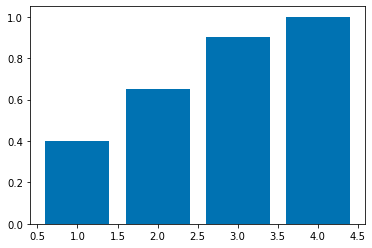

In [15]:
plt.bar(range(1,5), np.cumsum(Pis));

In [18]:
rv  = npr.uniform()
print(rv)

0.7351137891300115


In [19]:
np.cumsum(Pis)<=rv

array([ True,  True, False, False])

In [22]:
np.where(np.cumsum(Pis)<=rv)[0][0]

0

In [23]:
def make_GaussianMixture(N, Means, Sigs, Pis):
    X = np.empty((0,Means.shape[1]))
    L = np.empty(0)
    for i in range(N):
        rv = npr.uniform()   # sample uniform RV
        
        GaussianChosen = np.where(rv <= np.cumsum(Pis))[0][0]
        L = np.append(L,GaussianChosen)
        X = np.append(X, np.array([npr.multivariate_normal(Means[GaussianChosen], 
                                                           np.eye(Means.shape[1])*Sigs[GaussianChosen])]), axis=0)
        
    return X, L

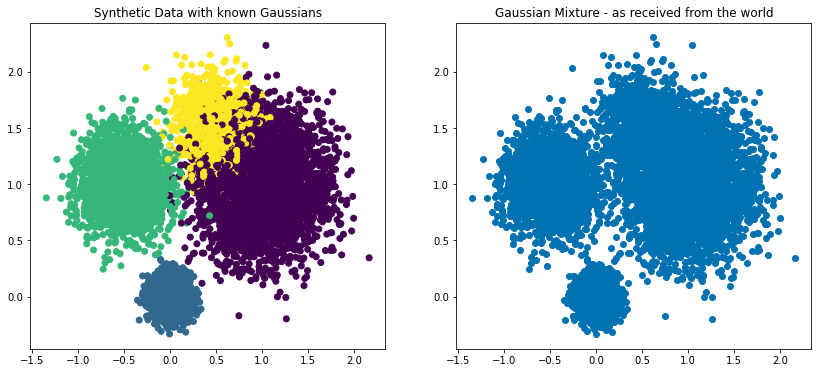

In [24]:
N = 10000
Means = np.array([[1,1],[0,0],[-.5, 1],[.5, 1.5]])
Sigs = [.1, .01, .05, .05]
Pis = [.4, .25, .25, .1]

X,L = make_GaussianMixture(N, Means, Sigs, Pis)

fig = plt.figure(figsize=(14,6))
fig.add_subplot(1,2,1)
plt.scatter(X[:,0],X[:,1], c=L)
plt.title('Synthetic Data with known Gaussians');
fig.add_subplot(1,2,2)
plt.scatter(X[:,0],X[:,1])
plt.title('Gaussian Mixture - as received from the world');

## Data Likelihood as a Gaussian Mixture Model

* GMMs can be used to learn a complex distribution that represent a dataset. Thus, it can be used within the probabilistic generative classifier framework to model complex data likelihoods.

* GMMs are also commonly used for **clustering**. Here a GMM is fit to a dataset with the goal of partitioning it into clusters.

**<font color=blue>Step 1</font>**

We can write the **observed data likelihood**, $\mathcal{L}^o$, as:

$$\mathcal{L}^0 = \prod_{i=1}^N p(x_i|\Theta)$$

where

$$p(x_i|\Theta) = \sum_{k=1}^K \pi_k N(x_i|\mu_k, \Sigma_k)$$

and

$$\Theta = \{\pi_k, \mu_k, \Sigma_k\}_{k=1}^K$$

Therefore, 

$$\mathcal{L}^0 = \prod_{i=1}^N \sum_{k=1}^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k)$$

**<font color=blue>Step 2</font>**

Let's apply our *trick*: log-likelihood.

\begin{align}
\mathcal{L} &= \ln\left(\prod_{i=1}^N \sum_{k=1}^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k)\right)\\
&= \sum_{i=1}^N \ln \left( \sum_{k=1}^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k) \right)
\end{align}

**<font color=blue>Step 3</font>**

Optimize for the parameters... 

$$\frac{\partial \mathcal{L}}{\partial \mu_k} = 0, \frac{\partial \mathcal{L}}{\partial \Sigma_k} = 0, \text{ and }, \frac{\partial \mathcal{L}}{\partial \pi_k} = 0$$


but this is a difficult problem to maximize!

* A common approach for estimating the parameters of a GMM given a data set is by using the **Expectation-Maximization (EM) algorithm**.

### Applications of (Gaussian) Mixture Models

* **Data Representation and Inference**. Represent *any* data set using a complex distribution. You may want to describe your data with a distribution but the data does not fit into a standard form (e.g. Gamma, Gaussian, Exponential, etc.), then you can use a (Gaussian) Mixture Model to describe the data. Having a representation of your data in a distribution form is a very powerful tool that, other than having a model of the data, allows you infer about new samples, make predictions, etc.
    * Having a parametric form for a real world model, allows us to apply it in simulation and use it for designing/optimizing decision-making solutions.

* **Clustering.** Partition the data into groups. Note that in the GMMs formulation we did not add the concept of labels/targets. So GMMs are an **unsupervised learning** model. It represents the data with a very complex likelihood and then we can decompose that likelihood to partition the data into categories. This is also known as **clustering**.
    * Commonly used in financial institutions to learn different group of individuals with specific characteristics of interest.

# Expectation-Maximization (EM) algorithm

Consider the observation of i.i.d. samples $x_1, x_2, \dots, x_N$ from the data likelihood $p(\mathbf{x}|\Theta)$ and we want to estimate the parameters (using MLE approach, for example)

\begin{align}
& \arg_{\Theta} \max p(\mathbf{x}|\Theta) \\
= & \arg_{\Theta} \max \prod_{i=1}^N p(x_i|\Theta) 
\end{align}

Now suppose the data samples $x_1, x_2, \dots, x_N$ are **censored**.

For example, suppose we observe i.i.d. samples, $x_1, x_2, \dots, x_N$, from some sensor $f(\mathbf{x})$. This sensor returns censored data in the form,

\begin{align}
f(\mathbf{x}) = \begin{cases} x, &&\text{ if }  x < a \\ a && \text{ if }x\geq a \end{cases}
\end{align}

This means that we see $x_1, x_2,\dots, x_m$ (less than $a$) and we do not see $x_{m+1}, x_{m+2}, \dots, x_N$ which are censored and set to $a$.

* An example of such censored data would be a scale that can only measure weight up to 120 lbs. Any measurements above 120 would be *censored* at 120.

* Given this censored data, we want to estimate the mean of the data as if the data was uncensored.

For this case, we can write our *observed* data likelihood as:

$$\mathcal{L}^0 = \prod_{i=1}^m p(x_i|\Theta) \prod_{j=m+1}^N \int_a^{\infty} p(x_j|\Theta) dx_j$$

The data likelihood would be very difficult to maximize to solve for $\Theta$.

If only we *knew* what the missing/censored data, the problem would be easy to solve!

## Hidden Latent Variables

The **Expectation-Maximization** or **EM** algorithm is used to find the Maximum Likelihood Estimators (MLE) (or MAP estimators) for model parameters when data is incomplete, has missing data points, or has unobserved (hidden) latent variables (such as the case of censored data). 

* For all of these cases, the MLE optimization is very difficult to obtain by simply taking the derivative and solve for the parameters.

**<font color=orange>Step 1</font>**
The first step of EM is to characterized the observed likelihood $\mathcal{L}^0$.

**<font color=orange>Step 2</font>**
Introduce *hidden latent variables* (also referred to as *hidden variables*) that simplify the observed data likelihood, $\mathcal{L}$.

**<font color=orange>Step 3</font>**
Use the hidden variables to define the *complete likelihood* $\mathcal{L}^c$.

With this, we build an objective function:

$$\arg_{z,\Theta} \max E[\ln(\mathcal{L^c})|X,\Theta^t]$$

where $Q(\Theta,\Theta^t) = E[\ln(\mathcal{L^c})|X,\Theta^t]$, $E[\bullet]$ denotes expected value and $t$ denotes *iteration*. At $t=0$, we start with random values for the parameters $\Theta$.

Once we have this, the EM algorithm will alternate between E-step and M-step:

1. **<font color=blue>E-step</font> (Expectation step)** Estimate the hidden variables. While holding $\Theta$ fixed, find the variables $z$ that maximize $E[\ln(\mathcal{L^c})]$.

2. **<font color=blue>M-step</font> (Maximization step)** Estimate the parameters of the complete data likelihood $\mathcal{L}^c$. While holding the newly found variables $z$, find the best values for the parameters $\Theta$ that maximize $E[\ln(\mathcal{L^c})]$.

and it keeps iterating between E-step and M-step until convergence or until a certain number of iterations is reached.

* EM is a general algorithm that can be applied to a variety of problems (not just the examples we are learning today). 

* EM is heavily tied with Maximum Likelihood Estimation (MLE). It is commonly used to simplify difficult MLE problems.
    * It was originally introduced by Dempster, Laird, and Rubin in 1977 in a paper called "Maximum Likelihood from Incomplete Data via the EM Algorithm".

**Censored Data Example**

Coming back to the censored data example, if we had observed the missing/censored data, we problem would be easy to solve. It would simplify to a standard MLE optimization.

We can use EM in our censored data. For now, let's consider $\mathbf{z}$ the hidden variables that represent the missing data. With this, we can write the *complete data likelihood* as:

$$\mathcal{L}^c = \prod_{i=1}^m p(x_i|\Theta) \prod_{j=m+1}^N p(z_j|\Theta)$$

* Note that you cannot just use $a$ for the censored data, it would skew the results!

The complete likelihood is much simpler to optimize, but then we need to define hidden variables $z$.

## Optimizing GMM with the EM Algorithm

The observed data likelihood for a Gaussian Mixture Model (GMM) is

$$\mathcal{L}^0 = \prod_{i=1}^N \sum_{k=1}^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k)$$

**What hidden variables can we add to simplify this problem?**

<!--* In this example, a hidden variable can be the label of the Gaussian from which $x_i$ was drawn from.

$$z_i: \text{label of the Gaussian from which $x_i$ was drawn from}$$

If we know $z_i$, then for each data point we know which Gaussian it was drawn from along with its respective parameter $\mu_{z_i}$ and $\Sigma_{z_i}$ and its respective weight $\pi_{z_i}$. So, each data point would had been drawn from $\pi_{z_i}N(x_i|\mu_{z_i}, \Sigma_{z_i})$. 

Then, assuming we have $\{z_i\}_{i=1}^N$, we can write the complete data likelihood:

$$\mathcal{L}^c = \prod_{i=1}^N \pi_{z_i}\mathcal{N}(x_i|\mathbf{\mu}_{z_i},\Sigma_{z_i})$$ 

Now we can iterate between the **E-step** and **M-step** of the EM algorithm until we find convergence or we have reached a threshold for a number of iterations. -->

# Food for Thought

In preparing for next class, think about how would you extend the objective function

$$Q(\Theta,\Theta^t) = E[\ln(\mathcal{L^c})|X,\Theta^t]$$

using what you know about the expected value for continuous random variables?